In [1]:

# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


In [4]:
import os
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm

# --- CONFIGURATION ---
BASE_PATH = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/CPM-17")

def analyze_shapes(folder_name):
    img_dir = BASE_PATH / folder_name / "Images"
    
    if not img_dir.exists():
        print(f"❌ {folder_name}: Directory not found")
        return

    print(f"\n📂 Scanning {folder_name}...")
    
    shapes = {}
    files = sorted(list(img_dir.glob("*.png")))
    
    for p in tqdm(files):
        img = cv2.imread(str(p))
        if img is None:
            print(f"  ⚠️ Read error: {p.name}")
            continue
            
        h, w = img.shape[:2]
        shape_key = f"{h}x{w}"
        
        if shape_key not in shapes:
            shapes[shape_key] = []
        shapes[shape_key].append(p.name)

    # Print summary
    print(f"  found {len(files)} images.")
    print(f"  Unique shapes found:")
    for shape, file_list in shapes.items():
        print(f"    • {shape}: {len(file_list)} images (e.g., {file_list[0]})")

if __name__ == "__main__":
    print("="*60)
    print("📏 CPM-17 Image Size Inspector")
    print("="*60)
    
    analyze_shapes("train")
    analyze_shapes("test")

📏 CPM-17 Image Size Inspector

📂 Scanning train...


100%|██████████| 32/32 [00:00<00:00, 66.44it/s]


  found 32 images.
  Unique shapes found:
    • 500x500: 25 images (e.g., image_00.png)
    • 600x600: 7 images (e.g., image_02.png)

📂 Scanning test...


100%|██████████| 32/32 [00:00<00:00, 65.76it/s]

  found 32 images.
  Unique shapes found:
    • 600x600: 13 images (e.g., image_00.png)
    • 500x500: 19 images (e.g., image_05.png)


In [5]:
import os
import glob
import numpy as np
import zarr
import pandas as pd
import cv2
import scipy.io
from pathlib import Path
from tqdm import tqdm
import numcodecs

# --- CONFIGURATION ---
BASE_PATH = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/CPM-17")
OUTPUT_BASE = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/cpm17/zarr_data")

PATCH_SIZE = 512
STRIDE = 400  # Stride for 600x600 images (High overlap to cover 600px well)
cv2.setNumThreads(0)

# ---------------------------------------------------------------------
# 1. Helper: Read Masks
# ---------------------------------------------------------------------
def read_mat_mask(mat_path):
    try:
        mat = scipy.io.loadmat(str(mat_path))
        possible_keys = ['inst_map', 'instance_map', 'map', 'mask', 'scmap']
        mask = None
        for key in possible_keys:
            if key in mat:
                mask = mat[key]
                break
        if mask is None:
            for key, val in mat.items():
                if isinstance(val, np.ndarray) and val.ndim == 2 and key not in ['__header__', '__version__', '__globals__']:
                    mask = val
                    break
        return mask.astype(np.int32) if mask is not None else None
    except Exception as e:
        print(f"❌ Error reading .mat {mat_path.name}: {e}")
        return None

# ---------------------------------------------------------------------
# 2. Logic: Pad AND/OR Tile
# ---------------------------------------------------------------------
def process_image(img, mask, patch_size=512, stride=400):
    """
    Handles both 500x500 (padding) and 600x600 (tiling).
    Returns a list of 512x512 patches.
    """
    h, w = img.shape[:2]
    results = []

    # --- STEP 1: Pad if smaller than 512 ---
    # If 500x500, this makes it 512x512.
    # If 600x600, this does nothing (pad=0).
    pad_h = max(0, patch_size - h)
    pad_w = max(0, patch_size - w)
    
    if pad_h > 0 or pad_w > 0:
        img = np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant', constant_values=0)
        mask = np.pad(mask, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
        h, w = img.shape[:2] # Update dimensions (now at least 512)

    # --- STEP 2: Tile (handles 512x512 exact and 600x600+) ---
    # Even if we just padded 500->512, this loop runs once and extracts the single 512 patch.
    
    # Calculate crop coordinates
    y_steps = list(range(0, h - patch_size + 1, stride))
    if (h - patch_size) % stride != 0:
        y_steps.append(h - patch_size) # Add last valid crop (shift back)
        
    x_steps = list(range(0, w - patch_size + 1, stride))
    if (w - patch_size) % stride != 0:
        x_steps.append(w - patch_size) # Add last valid crop (shift back)

    # Unique & Sort
    y_steps = sorted(list(set(y_steps)))
    x_steps = sorted(list(set(x_steps)))

    for y in y_steps:
        for x in x_steps:
            img_patch = img[y:y+patch_size, x:x+patch_size, :]
            mask_patch = mask[y:y+patch_size, x:x+patch_size]
            
            results.append({
                'image': img_patch,
                'mask': mask_patch,
                'y': y,
                'x': x,
                'padded': (pad_h > 0 or pad_w > 0)
            })
            
    return results

# ---------------------------------------------------------------------
# 3. Process Folders
# ---------------------------------------------------------------------
def process_split_folder(split_name, folder_name):
    img_dir = BASE_PATH / folder_name / "Images"
    lbl_dir = BASE_PATH / folder_name / "Labels"
    
    if not img_dir.exists():
        print(f"⚠️  Skipping {split_name}: Not found")
        return 0, 0

    print(f"\n📂 Processing {split_name} (Source: {folder_name})...")
    img_files = sorted(list(img_dir.glob("*.png")))
    
    all_patches_img = []
    all_patches_mask = []
    all_metadata = []
    
    for img_path in tqdm(img_files, desc=f"  Processing {split_name}"):
        mask_path = lbl_dir / (img_path.stem + ".mat")
        if not mask_path.exists(): continue
            
        img = cv2.imread(str(img_path))
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = read_mat_mask(mask_path)
        if mask is None: continue
        
        # Apply Hybrid Logic
        patches = process_image(img, mask, PATCH_SIZE, STRIDE)
        
        for p in patches:
            all_patches_img.append(p['image'])
            all_patches_mask.append(p['mask'])
            all_metadata.append({
                'original_file': img_path.name,
                'original_h': img.shape[0],
                'original_w': img.shape[1],
                'patch_y': p['y'],
                'patch_x': p['x'],
                'was_padded': p['padded']
            })

    if not all_patches_img:
        return 0, 0

    final_images = np.stack(all_patches_img, axis=0)
    final_masks = np.stack(all_patches_mask, axis=0)
    
    # Save
    save_dir = OUTPUT_BASE / split_name
    os.makedirs(save_dir, exist_ok=True)
    compressor = numcodecs.Blosc(cname='zstd', clevel=3)
    
    z_img = zarr.open_array(str(save_dir / 'images.zarr'), mode='w', shape=final_images.shape, chunks=(1, 512, 512, 3), dtype='uint8', compressor=compressor)
    z_img[:] = final_images
    
    z_mask = zarr.open_array(str(save_dir / 'nuclei_masks.zarr'), mode='w', shape=final_masks.shape, chunks=(1, 512, 512), dtype='int32', compressor=compressor)
    z_mask[:] = final_masks
    
    pd.DataFrame(all_metadata).to_csv(save_dir / 'metadata.csv', index=False)
    
    print(f"   ✅ Saved {len(final_images)} tiles to {split_name}")
    return len(final_images), 0

# ---------------------------------------------------------------------
# 4. Main
# ---------------------------------------------------------------------
if __name__ == "__main__":
    print("="*70)
    print("🔬 CPM-17 Hybrid Processing (Pad 500px, Tile 600px)")
    print("="*70)
    
    OUTPUT_BASE.mkdir(parents=True, exist_ok=True)
    splits = {'cpm17_train': 'train', 'cpm17_test': 'test'}
    
    for out, src in splits.items():
        process_split_folder(out, src)
        
    print("\n✅ DONE")

🔬 CPM-17 Hybrid Processing (Pad 500px, Tile 600px)

📂 Processing cpm17_train (Source: train)...


  Processing cpm17_train: 100%|██████████| 32/32 [00:00<00:00, 43.74it/s]


   ✅ Saved 53 tiles to cpm17_train

📂 Processing cpm17_test (Source: test)...


  Processing cpm17_test: 100%|██████████| 32/32 [00:00<00:00, 33.34it/s]


   ✅ Saved 71 tiles to cpm17_test

✅ DONE


## Val

In [1]:
import os
import glob
import numpy as np
import zarr
import pandas as pd
import cv2
import scipy.io
from pathlib import Path
from tqdm import tqdm
import numcodecs

# --- CONFIGURATION ---
BASE_PATH = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/CPM-17")
OUTPUT_BASE = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/cpm17/zarr_data")

PATCH_SIZE = 512
STRIDE = 400
VAL_SPLIT = 0.05  # 5% for validation
SEED = 42         # Ensure reproducibility of the split

cv2.setNumThreads(0)
np.random.seed(SEED)

# ---------------------------------------------------------------------
# 1. Helper: Read Masks
# ---------------------------------------------------------------------
def read_mat_mask(mat_path):
    try:
        mat = scipy.io.loadmat(str(mat_path))
        possible_keys = ['inst_map', 'instance_map', 'map', 'mask', 'scmap']
        mask = None
        for key in possible_keys:
            if key in mat:
                mask = mat[key]
                break
        if mask is None:
            for key, val in mat.items():
                if isinstance(val, np.ndarray) and val.ndim == 2 and key not in ['__header__', '__version__', '__globals__']:
                    mask = val
                    break
        return mask.astype(np.int32) if mask is not None else None
    except Exception as e:
        print(f"❌ Error reading .mat {mat_path.name}: {e}")
        return None

# ---------------------------------------------------------------------
# 2. Logic: Pad AND/OR Tile
# ---------------------------------------------------------------------
def process_image(img, mask, patch_size=512, stride=400):
    h, w = img.shape[:2]
    results = []

    # --- STEP 1: Pad if smaller than 512 ---
    pad_h = max(0, patch_size - h)
    pad_w = max(0, patch_size - w)
    
    if pad_h > 0 or pad_w > 0:
        img = np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant', constant_values=0)
        mask = np.pad(mask, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
        h, w = img.shape[:2] 

    # --- STEP 2: Tile ---
    y_steps = list(range(0, h - patch_size + 1, stride))
    if (h - patch_size) % stride != 0:
        y_steps.append(h - patch_size)
        
    x_steps = list(range(0, w - patch_size + 1, stride))
    if (w - patch_size) % stride != 0:
        x_steps.append(w - patch_size)

    y_steps = sorted(list(set(y_steps)))
    x_steps = sorted(list(set(x_steps)))

    for y in y_steps:
        for x in x_steps:
            img_patch = img[y:y+patch_size, x:x+patch_size, :]
            mask_patch = mask[y:y+patch_size, x:x+patch_size]
            
            results.append({
                'image': img_patch,
                'mask': mask_patch,
                'y': y,
                'x': x,
                'padded': (pad_h > 0 or pad_w > 0)
            })
            
    return results

# ---------------------------------------------------------------------
# 3. Process List of Files (Refactored)
# ---------------------------------------------------------------------
def process_file_list(file_list, split_name, lbl_dir_path):
    """
    Processes a specific list of image files and saves them to a Zarr group.
    """
    print(f"\n📂 Processing {split_name} with {len(file_list)} images...")
    
    all_patches_img = []
    all_patches_mask = []
    all_metadata = []
    
    for img_path in tqdm(file_list, desc=f"  Processing {split_name}"):
        # Find corresponding mask
        mask_path = lbl_dir_path / (img_path.stem + ".mat")
        if not mask_path.exists(): 
            # Fallback: sometimes extension cases differ, check carefully if needed
            print(f"⚠️ Mask not found for {img_path.name}")
            continue
            
        img = cv2.imread(str(img_path))
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = read_mat_mask(mask_path)
        if mask is None: continue
        
        # Apply Hybrid Logic
        patches = process_image(img, mask, PATCH_SIZE, STRIDE)
        
        for p in patches:
            all_patches_img.append(p['image'])
            all_patches_mask.append(p['mask'])
            all_metadata.append({
                'original_file': img_path.name,
                'original_h': img.shape[0],
                'original_w': img.shape[1],
                'patch_y': p['y'],
                'patch_x': p['x'],
                'was_padded': p['padded']
            })

    if not all_patches_img:
        print(f"⚠️ No patches created for {split_name}")
        return

    final_images = np.stack(all_patches_img, axis=0)
    final_masks = np.stack(all_patches_mask, axis=0)
    
    # Save to Zarr
    save_dir = OUTPUT_BASE / split_name
    # Clean up previous if exists (optional, but good for safety) or just overwrite
    if save_dir.exists():
        import shutil
        shutil.rmtree(save_dir)
    os.makedirs(save_dir, exist_ok=True)
    
    compressor = numcodecs.Blosc(cname='zstd', clevel=3)
    
    print(f"  💾 Saving Zarr arrays to {save_dir}...")
    z_img = zarr.open_array(str(save_dir / 'images.zarr'), mode='w', shape=final_images.shape, chunks=(1, 512, 512, 3), dtype='uint8', compressor=compressor)
    z_img[:] = final_images
    
    z_mask = zarr.open_array(str(save_dir / 'nuclei_masks.zarr'), mode='w', shape=final_masks.shape, chunks=(1, 512, 512), dtype='int32', compressor=compressor)
    z_mask[:] = final_masks
    
    pd.DataFrame(all_metadata).to_csv(save_dir / 'metadata.csv', index=False)
    
    print(f"  ✅ DONE: {split_name} | Images: {len(file_list)} | Patches: {len(final_images)}")

# ---------------------------------------------------------------------
# 4. Main Execution
# ---------------------------------------------------------------------
if __name__ == "__main__":
    print("="*70)
    print("🔬 CPM-17 Hybrid Processing with Train/Val Split")
    print("="*70)
    
    OUTPUT_BASE.mkdir(parents=True, exist_ok=True)

    # --- 1. Process TEST Set (No Split) ---
    test_img_dir = BASE_PATH / "test" / "Images"
    test_lbl_dir = BASE_PATH / "test" / "Labels"
    
    if test_img_dir.exists():
        test_files = sorted(list(test_img_dir.glob("*.png")))
        process_file_list(test_files, "cpm17_test", test_lbl_dir)
    else:
        print("⚠️ Test folder not found, skipping.")

    # --- 2. Process TRAIN Set (With Split) ---
    train_img_dir = BASE_PATH / "train" / "Images"
    train_lbl_dir = BASE_PATH / "train" / "Labels"

    if train_img_dir.exists():
        # Get all train files
        all_train_files = sorted(list(train_img_dir.glob("*.png")))
        total_train = len(all_train_files)
        
        # Shuffle and Split
        # We split by FILE, not by patch, to avoid data leakage
        shuffled_indices = np.random.permutation(total_train)
        val_size = int(total_train * VAL_SPLIT)
        train_size = total_train - val_size
        
        val_indices = shuffled_indices[:val_size]
        train_indices = shuffled_indices[val_size:]
        
        train_files_split = [all_train_files[i] for i in train_indices]
        val_files_split = [all_train_files[i] for i in val_indices]
        
        print(f"\n📊 Splitting Source Train Data ({total_train} images):")
        print(f"   Training:   {len(train_files_split)} images")
        print(f"   Validation: {len(val_files_split)} images")
        
        # Process the split lists
        process_file_list(train_files_split, "cpm17_train", train_lbl_dir)
        process_file_list(val_files_split, "cpm17_val", train_lbl_dir)
        
    else:
        print("⚠️ Train folder not found, skipping.")
        
    print("\n✅ ALL PROCESSING DONE")

🔬 CPM-17 Hybrid Processing with Train/Val Split

📂 Processing cpm17_test with 32 images...


  Processing cpm17_test: 100%|██████████| 32/32 [00:01<00:00, 25.64it/s]


  💾 Saving Zarr arrays to /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/cpm17/zarr_data/cpm17_test...
  ✅ DONE: cpm17_test | Images: 32 | Patches: 71

📊 Splitting Source Train Data (32 images):
   Training:   31 images
   Validation: 1 images

📂 Processing cpm17_train with 31 images...


  Processing cpm17_train: 100%|██████████| 31/31 [00:01<00:00, 23.20it/s]


  💾 Saving Zarr arrays to /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/cpm17/zarr_data/cpm17_train...
  ✅ DONE: cpm17_train | Images: 31 | Patches: 52

📂 Processing cpm17_val with 1 images...


  Processing cpm17_val: 100%|██████████| 1/1 [00:00<00:00, 28.27it/s]

  💾 Saving Zarr arrays to /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/cpm17/zarr_data/cpm17_val...
  ✅ DONE: cpm17_val | Images: 1 | Patches: 1

✅ ALL PROCESSING DONE


In [ ]:
import os
import glob
import numpy as np
import zarr
import pandas as pd
import cv2
import scipy.io
from pathlib import Path
from tqdm import tqdm
import numcodecs

# --- CONFIGURATION ---
BASE_PATH = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/CPM-17")
OUTPUT_BASE = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/cpm17/zarr_data")

PATCH_SIZE = 512
STRIDE = 400  # Stride for 600x600 images (High overlap to cover 600px well)
cv2.setNumThreads(0)

# ---------------------------------------------------------------------
# 1. Helper: Read Masks
# ---------------------------------------------------------------------
def read_mat_mask(mat_path):
    try:
        mat = scipy.io.loadmat(str(mat_path))
        possible_keys = ['inst_map', 'instance_map', 'map', 'mask', 'scmap']
        mask = None
        for key in possible_keys:
            if key in mat:
                mask = mat[key]
                break
        if mask is None:
            for key, val in mat.items():
                if isinstance(val, np.ndarray) and val.ndim == 2 and key not in ['__header__', '__version__', '__globals__']:
                    mask = val
                    break
        return mask.astype(np.int32) if mask is not None else None
    except Exception as e:
        print(f"❌ Error reading .mat {mat_path.name}: {e}")
        return None

# ---------------------------------------------------------------------
# 2. Logic: Pad AND/OR Tile
# ---------------------------------------------------------------------
def process_image(img, mask, patch_size=512, stride=400):
    """
    Handles both 500x500 (padding) and 600x600 (tiling).
    Returns a list of 512x512 patches.
    """
    h, w = img.shape[:2]
    results = []

    # --- STEP 1: Pad if smaller than 512 ---
    # If 500x500, this makes it 512x512.
    # If 600x600, this does nothing (pad=0).
    pad_h = max(0, patch_size - h)
    pad_w = max(0, patch_size - w)
    
    if pad_h > 0 or pad_w > 0:
        img = np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant', constant_values=0)
        mask = np.pad(mask, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
        h, w = img.shape[:2] # Update dimensions (now at least 512)

    # --- STEP 2: Tile (handles 512x512 exact and 600x600+) ---
    # Even if we just padded 500->512, this loop runs once and extracts the single 512 patch.
    
    # Calculate crop coordinates
    y_steps = list(range(0, h - patch_size + 1, stride))
    if (h - patch_size) % stride != 0:
        y_steps.append(h - patch_size) # Add last valid crop (shift back)
        
    x_steps = list(range(0, w - patch_size + 1, stride))
    if (w - patch_size) % stride != 0:
        x_steps.append(w - patch_size) # Add last valid crop (shift back)

    # Unique & Sort
    y_steps = sorted(list(set(y_steps)))
    x_steps = sorted(list(set(x_steps)))

    for y in y_steps:
        for x in x_steps:
            img_patch = img[y:y+patch_size, x:x+patch_size, :]
            mask_patch = mask[y:y+patch_size, x:x+patch_size]
            
            results.append({
                'image': img_patch,
                'mask': mask_patch,
                'y': y,
                'x': x,
                'padded': (pad_h > 0 or pad_w > 0)
            })
            
    return results

# ---------------------------------------------------------------------
# 3. Process Folders
# ---------------------------------------------------------------------
def process_split_folder(split_name, folder_name):
    img_dir = BASE_PATH / folder_name / "Images"
    lbl_dir = BASE_PATH / folder_name / "Labels"
    
    if not img_dir.exists():
        print(f"⚠️  Skipping {split_name}: Not found")
        return 0, 0

    print(f"\n📂 Processing {split_name} (Source: {folder_name})...")
    img_files = sorted(list(img_dir.glob("*.png")))
    
    all_patches_img = []
    all_patches_mask = []
    all_metadata = []
    
    for img_path in tqdm(img_files, desc=f"  Processing {split_name}"):
        mask_path = lbl_dir / (img_path.stem + ".mat")
        if not mask_path.exists(): continue
            
        img = cv2.imread(str(img_path))
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = read_mat_mask(mask_path)
        if mask is None: continue
        
        # Apply Hybrid Logic
        patches = process_image(img, mask, PATCH_SIZE, STRIDE)
        
        for p in patches:
            all_patches_img.append(p['image'])
            all_patches_mask.append(p['mask'])
            all_metadata.append({
                'original_file': img_path.name,
                'original_h': img.shape[0],
                'original_w': img.shape[1],
                'patch_y': p['y'],
                'patch_x': p['x'],
                'was_padded': p['padded']
            })

    if not all_patches_img:
        return 0, 0

    final_images = np.stack(all_patches_img, axis=0)
    final_masks = np.stack(all_patches_mask, axis=0)
    
    # Save
    save_dir = OUTPUT_BASE / split_name
    os.makedirs(save_dir, exist_ok=True)
    compressor = numcodecs.Blosc(cname='zstd', clevel=3)
    
    z_img = zarr.open_array(str(save_dir / 'images.zarr'), mode='w', shape=final_images.shape, chunks=(1, 512, 512, 3), dtype='uint8', compressor=compressor)
    z_img[:] = final_images
    
    z_mask = zarr.open_array(str(save_dir / 'nuclei_masks.zarr'), mode='w', shape=final_masks.shape, chunks=(1, 512, 512), dtype='int32', compressor=compressor)
    z_mask[:] = final_masks
    
    pd.DataFrame(all_metadata).to_csv(save_dir / 'metadata.csv', index=False)
    
    print(f"   ✅ Saved {len(final_images)} tiles to {split_name}")
    return len(final_images), 0

# ---------------------------------------------------------------------
# 4. Main
# ---------------------------------------------------------------------
if __name__ == "__main__":
    print("="*70)
    print("🔬 CPM-17 Hybrid Processing (Pad 500px, Tile 600px)")
    print("="*70)
    
    OUTPUT_BASE.mkdir(parents=True, exist_ok=True)
    splits = {'cpm17_train': 'train', 'cpm17_test': 'test'}
    
    for out, src in splits.items():
        process_split_folder(out, src)
        
    print("\n✅ DONE")

👀 INSPECTING HYBRID CPM-17 DATA: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/cpm17/zarr_data

📂 CPM17_TRAIN | Total Tiles: 53


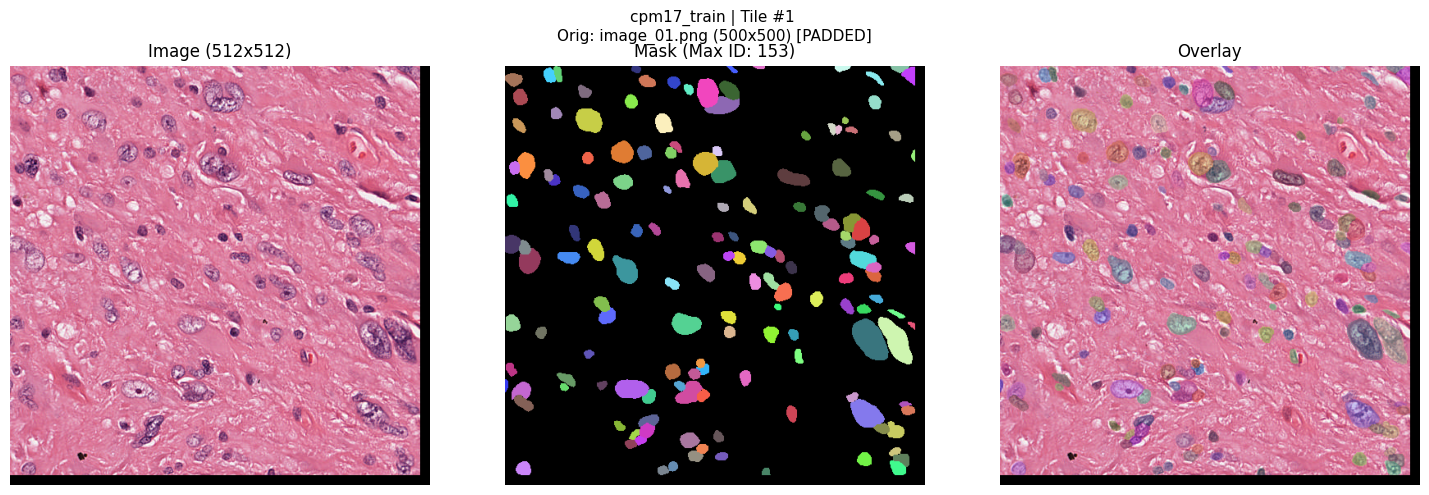

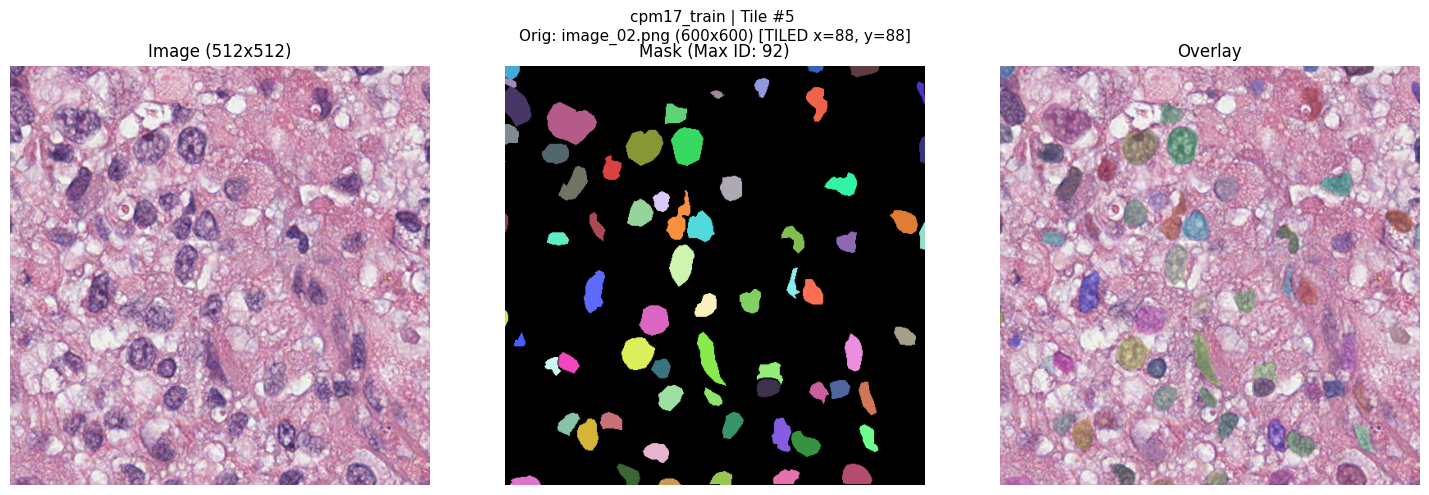

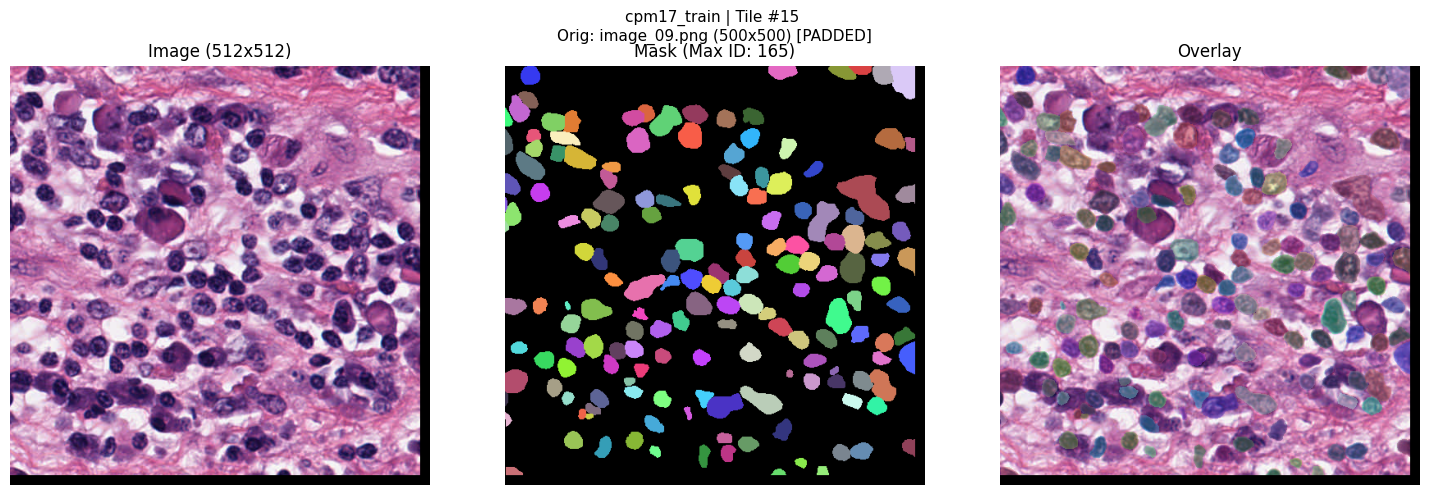

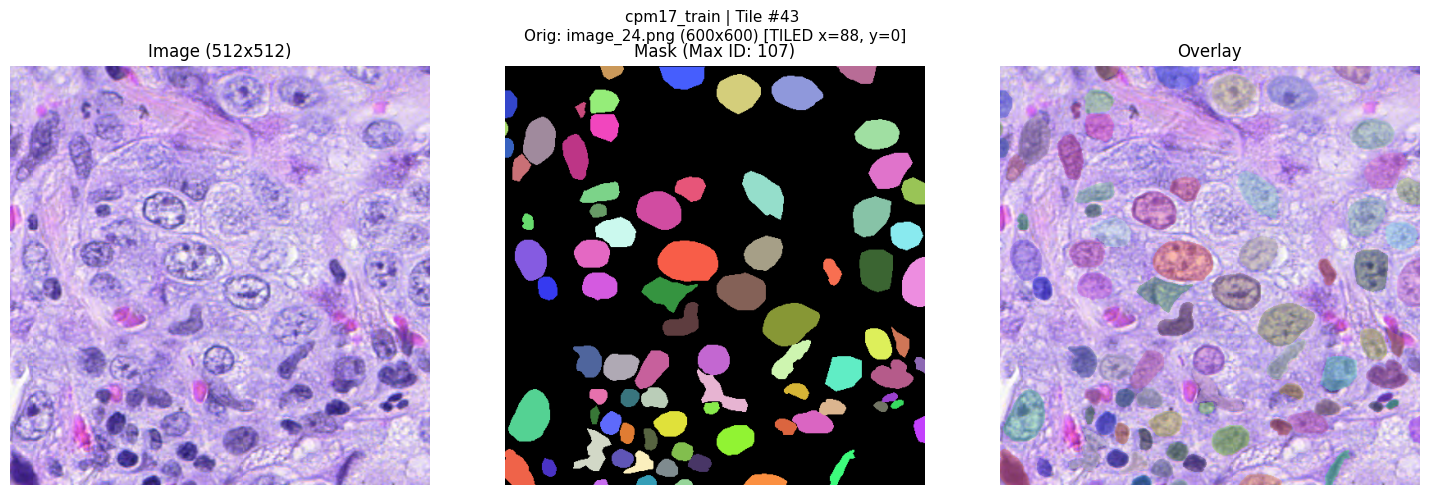


📂 CPM17_TEST | Total Tiles: 71


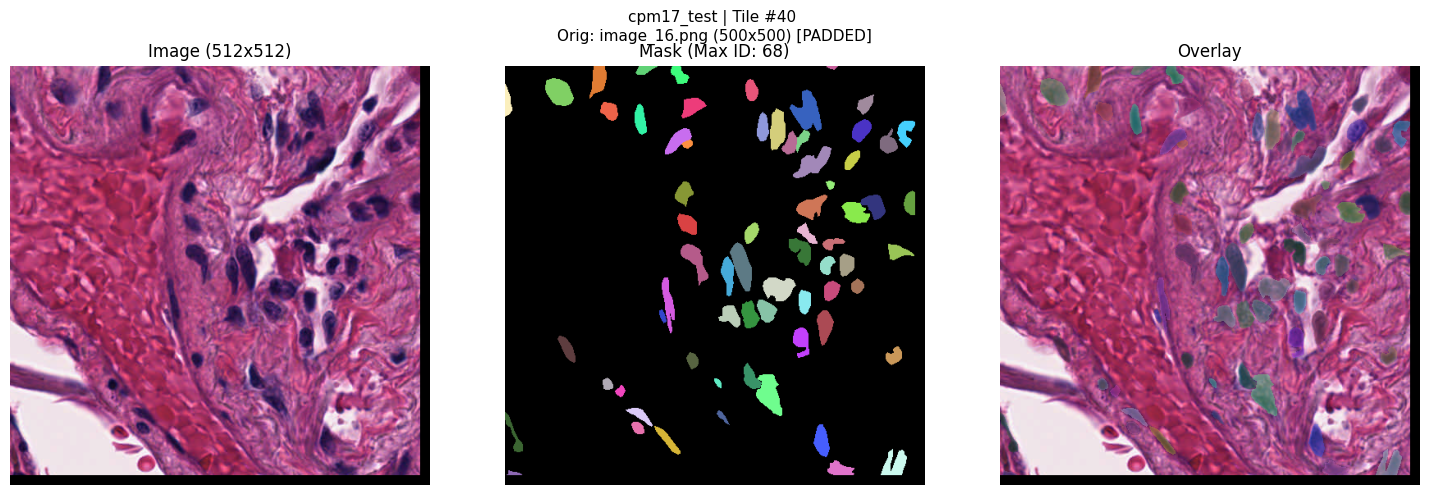

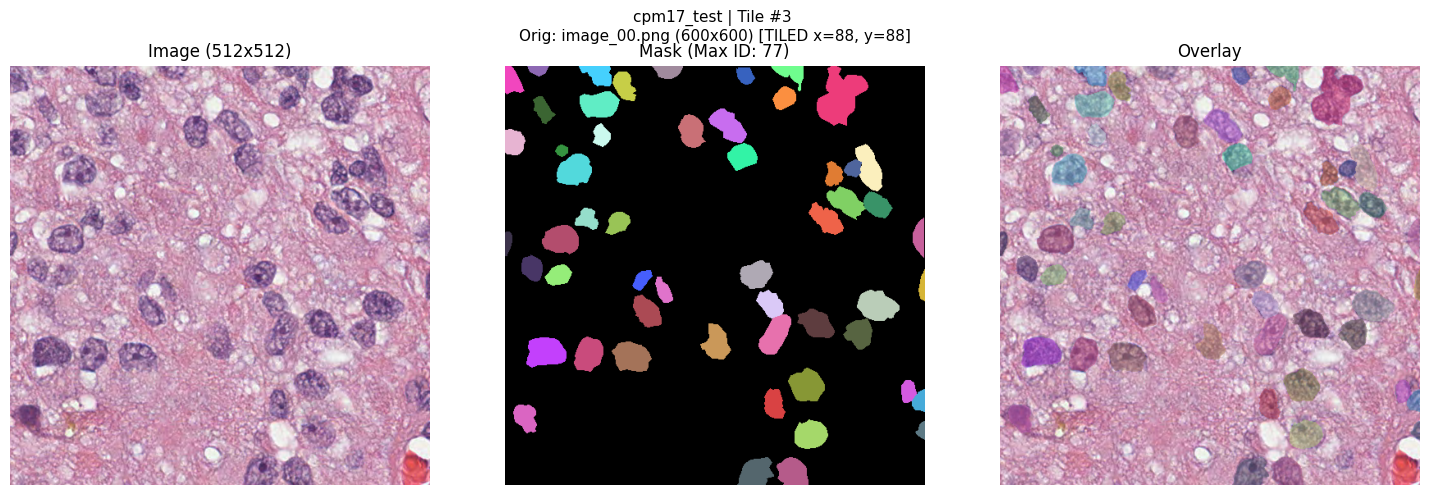

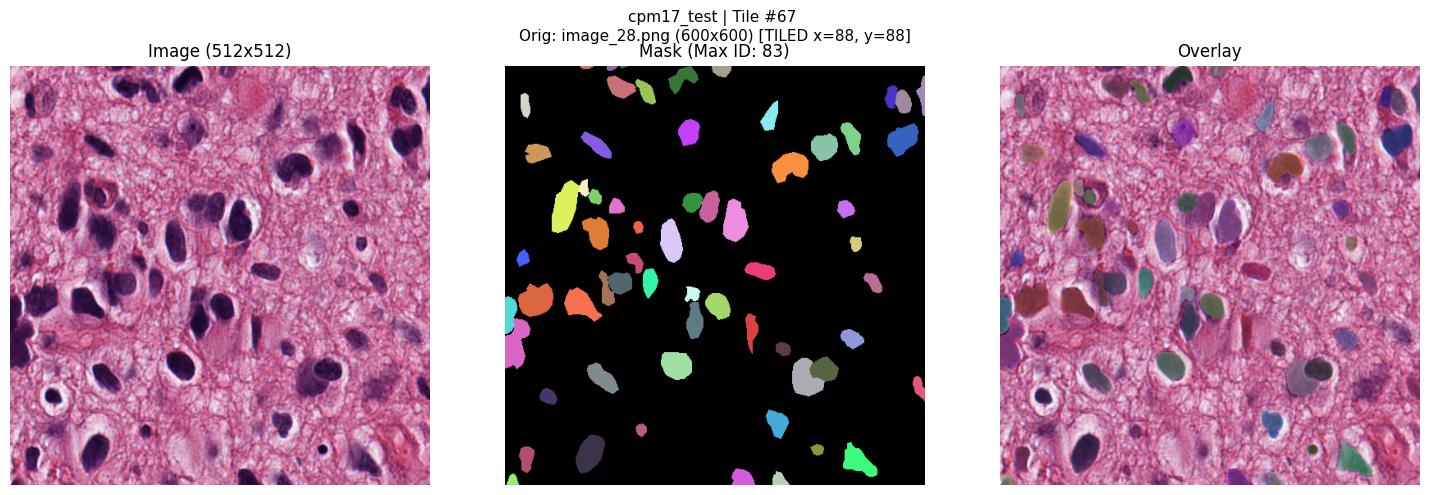

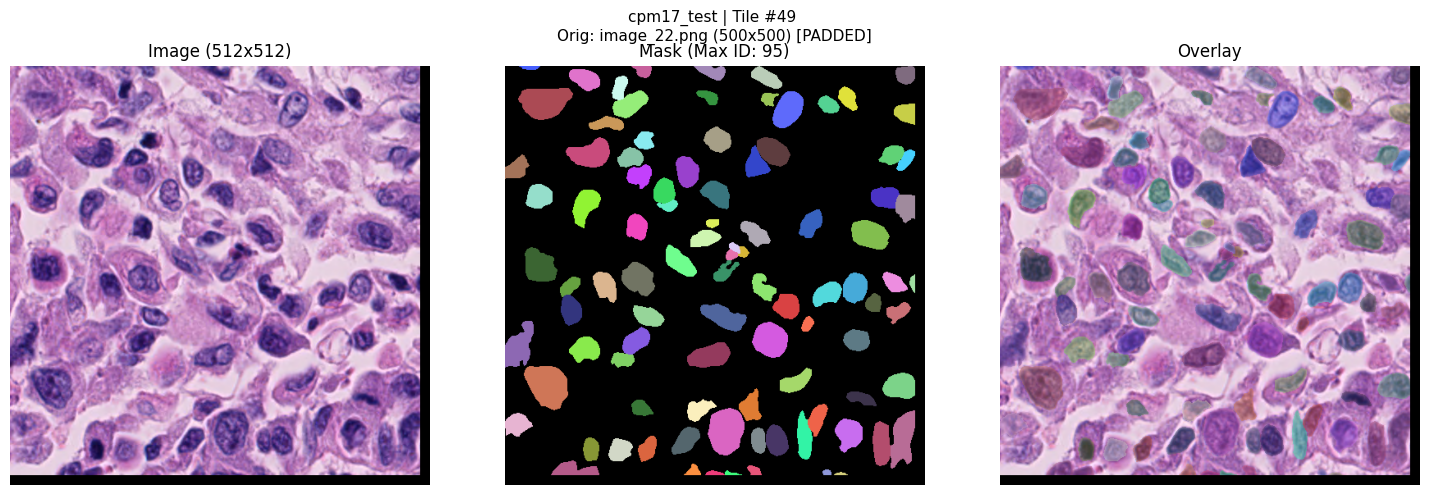

In [6]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from pathlib import Path
import pandas as pd

# --- CONFIGURATION ---
ZARR_DATA_ROOT = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/cpm17/zarr_data")

def colorize_instances(mask):
    max_id = int(mask.max())
    if max_id == 0: return np.zeros((*mask.shape, 3), dtype=np.uint8)
    np.random.seed(42) 
    colors = np.random.randint(50, 255, size=(max_id + 1, 3), dtype=np.uint8)
    colors[0] = [0, 0, 0]
    return colors[mask]

def visualize_dataset(root_path, samples_per_split=4):
    print("=" * 70)
    print(f"👀 INSPECTING HYBRID CPM-17 DATA: {root_path}")
    print("=" * 70)
    
    splits = ['cpm17_train', 'cpm17_test']
    
    for split_name in splits:
        split_path = root_path / split_name
        if not split_path.exists(): continue
            
        try:
            z_img = zarr.open(str(split_path / "images.zarr"), mode='r')
            z_msk = zarr.open(str(split_path / "nuclei_masks.zarr"), mode='r')
            metadata = pd.read_csv(split_path / "metadata.csv")
            
            print(f"\n📂 {split_name.upper()} | Total Tiles: {z_img.shape[0]}")
            
            # Select mixed samples: Try to find one padded (from 500) and one tiled (from 600)
            sample_indices = []
            
            # Find a padded sample (was 500x500)
            padded_indices = metadata[metadata['was_padded'] == True].index.tolist()
            if padded_indices: sample_indices.append(random.choice(padded_indices))
            
            # Find a tiled sample (was 600x600 - likely has non-zero x/y offset)
            tiled_indices = metadata[(metadata['was_padded'] == False) & (metadata['original_h'] > 512)].index.tolist()
            if tiled_indices: sample_indices.append(random.choice(tiled_indices))
            
            # Fill the rest with random
            while len(sample_indices) < samples_per_split:
                idx = random.randint(0, z_img.shape[0]-1)
                if idx not in sample_indices: sample_indices.append(idx)
            
            for idx in sample_indices:
                img = z_img[idx]
                mask = z_msk[idx]
                row = metadata.iloc[idx]
                
                info = f"\nOrig: {row['original_file']} ({row['original_h']}x{row['original_w']})"
                if row['was_padded']: info += " [PADDED]"
                else: info += f" [TILED x={row['patch_x']}, y={row['patch_y']}]"

                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                fig.suptitle(f"{split_name} | Tile #{idx} {info}", fontsize=11)
                
                ax[0].imshow(img)
                ax[0].set_title(f"Image ({img.shape[0]}x{img.shape[1]})")
                ax[0].axis('off')
                
                ax[1].imshow(colorize_instances(mask))
                ax[1].set_title(f"Mask (Max ID: {mask.max()})")
                ax[1].axis('off')
                
                overlay = img.copy().astype(float)
                colored_mask = colorize_instances(mask)
                alpha = np.where(mask > 0, 0.4, 0.0)[:,:,None]
                blended = (overlay * (1 - alpha) + colored_mask * alpha).astype(np.uint8)
                
                ax[2].imshow(blended)
                ax[2].set_title("Overlay")
                ax[2].axis('off')
                
                plt.tight_layout()
                plt.show()

        except Exception as e:
            print(f"❌ Error in {split_name}: {e}")

if __name__ == "__main__":
    if ZARR_DATA_ROOT.exists():
        visualize_dataset(ZARR_DATA_ROOT)
    else:
        print(f"❌ Path not found")